# SAP HANA Cloud Knowledge Graph Engine

>[SAP HANA Cloud Knowledge Graph](https://help.sap.com/docs/hana-cloud-database/sap-hana-cloud-sap-hana-database-knowledge-graph-guide/sap-hana-cloud-sap-hana-database-knowledge-graph-engine-guide) is a fully integrated knowledge graph solution within the `SAP HANA Cloud` database.
>
>This example demonstrates how to build a QA (Question-Answering) chain that queries [Resource Description Framework (RDF)](https://en.wikipedia.org/wiki/Resource_Description_Framework) data stored in an `SAP HANA Cloud` instance using the `SPARQL` query language, and returns a human-readable response.
>
>[SPARQL](https://en.wikipedia.org/wiki/SPARQL) is the standard query language for querying `RDF` graphs.


## Setup & Installation

**Prerequisite**:  
You must have an SAP HANA Cloud instance with the **triple store** feature enabled.  
For detailed instructions, refer to: [Enable Triple Store](https://help.sap.com/docs/hana-cloud-database/sap-hana-cloud-sap-hana-database-knowledge-graph-guide/enable-triple-store/)<br />
Load the `kgdocu_movies` example data. See [Knowledge Graph Example](https://help.sap.com/docs/hana-cloud-database/sap-hana-cloud-sap-hana-database-knowledge-graph-guide/knowledge-graph-example).

To use SAP HANA Knowledge Graph Engine and/or Vector Store Engine with LangChain, install the `langchain-hana` package:

In [1]:
import langchain_hana
print(langchain_hana.__version__)

0.2.2


First, create a connection to your SAP HANA Cloud instance.

In [1]:
import os

from dotenv import load_dotenv
from hdbcli import dbapi

# Load environment variables if needed
load_dotenv()

# Establish connection to SAP HANA Cloud
connection = dbapi.connect(
    address=os.environ.get("HANADB_URL"),
    port=os.environ.get("HANADB_PRT"),
    user=os.environ.get("HANADB_USR"),
    password=os.environ.get("HANADB_PWD"),
    autocommit=True,
    sslValidateCertificate=False,
)

## Initialize the `HanaRdfGraph`

To power the QA chain, you first need a `HanaRdfGraph` instance that:

1. Loads your ontology schema (in Turtle)  
2. Executes SPARQL queries against your SAP HANA Cloud data graph  

The constructor requires:

- **`connection`**: an active `hdbcli.dbapi.connect(...)` instance  
- **`graph_uri`**: the named graph (or `"DEFAULT"`) where your RDF data lives  
- **One of**:  
  1. `ontology_query`**: a SPARQL CONSTRUCT to extract schema triples  
  2. `ontology_uri`**: a hosted ontology graph URI  
  3. `ontology_local_file`** + **`ontology_local_file_format`**: a local Turtle/RDF file  
  4. `auto_extract_ontology=True`** (not recommended for production—see note)

`graph_uri` vs. Ontology
- **`graph_uri`**:  
  The named graph in your SAP HANA Cloud instance that contains your instance data (sometimes 100k+ triples).
  If `None` or `"DEFAULT"` is provided, the default graph is used.  
  ➔ More details: [Default Graph and Named Graphs](https://help.sap.com/docs/hana-cloud-database/sap-hana-cloud-sap-hana-database-knowledge-graph-guide/default-graph-and-named-graphs)
- **Ontology**: a lean schema (typically ~50-100 triples) describing classes, properties, domains, ranges, labels, comments, and subclass relationships. The ontology guides SPARQL generation and result interpretation.


## Example: Question Answering over a “Movies” Knowledge Graph

Below we’ll:

1. Instantiate the `HanaRdfGraph` pointing at our “movies” data graph  
2. Wrap it in a `HanaSparqlQAChain` powered by an LLM  
3. Ask natural-language questions and print out the chain’s responses  

This demonstrates how the LLM generates SPARQL under the hood, executes it against SAP HANA Cloud, and returns a human-readable answer.

We'll use the `sap-ai-sdk-gen` package. Check [sap-ai-sdk-gen](https://pypi.org/project/sap-ai-sdk-gen/) for futher details.

In [2]:
from langchain_hana import HanaRdfGraph, HanaSparqlQAChain

In [3]:
# Set up the Knowledge Graph
graph_uri = "kgdocu_movies"

graph = HanaRdfGraph(
    connection=connection, graph_uri=graph_uri, auto_extract_ontology=True
)

In [4]:
# a basic graph schema is extracted from the data graph. This schema will guide the LLM to generate a proper SPARQL query.
print(graph.get_schema)
schema_ttl = graph.get_schema

@prefix owl: <http://www.w3.org/2002/07/owl#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://kg.demo.sap.com/acted_in> a owl:ObjectProperty ;
    rdfs:label "acted_in" ;
    rdfs:domain <http://kg.demo.sap.com/Actor> ;
    rdfs:range <http://kg.demo.sap.com/Film> .

<http://kg.demo.sap.com/dateOfBirth> a owl:DatatypeProperty ;
    rdfs:label "dateOfBirth" ;
    rdfs:domain <http://kg.demo.sap.com/Actor> ;
    rdfs:range xsd:dateTime .

<http://kg.demo.sap.com/directed> a owl:ObjectProperty ;
    rdfs:label "directed" ;
    rdfs:domain <http://kg.demo.sap.com/Director> ;
    rdfs:range <http://kg.demo.sap.com/Film> .

<http://kg.demo.sap.com/genre> a owl:ObjectProperty ;
    rdfs:label "genre" ;
    rdfs:domain <http://kg.demo.sap.com/Film> ;
    rdfs:range <http://kg.demo.sap.com/Genre> .

<http://kg.demo.sap.com/placeOfBirth> a owl:ObjectProperty ;
    rdfs:label "placeOfBirth" ;
    rdfs:domain <http://kg.demo.sap

In [5]:
import rdflib
from rdflib.tools.rdf2dot import rdf2dot
import io
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import Markdown
import pandas as pd

ModuleNotFoundError: No module named 'networkx'

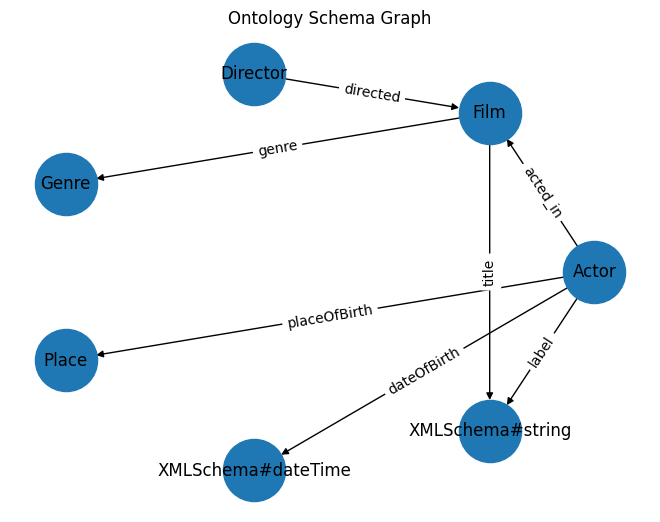

In [7]:
# Parse into an RDFLib graph
g = rdflib.Graph()
g.parse(data=graph.get_schema, format="turtle")

# Build a NetworkX graph
G = nx.DiGraph()

# Add edges based on domain-range relationships
for prop in g.subjects(rdflib.RDF.type, rdflib.OWL.ObjectProperty):
    domain = g.value(prop, rdflib.RDFS.domain)
    range_ = g.value(prop, rdflib.RDFS.range)
    label = g.value(prop, rdflib.RDFS.label) or prop.split('/')[-1]
    if domain and range_:
        d_label = domain.split('/')[-1]
        r_label = range_.split('/')[-1]
        G.add_node(d_label)
        G.add_node(r_label)
        G.add_edge(d_label, r_label, label=str(label))

for prop in g.subjects(rdflib.RDF.type, rdflib.OWL.DatatypeProperty):
    domain = g.value(prop, rdflib.RDFS.domain)
    range_ = g.value(prop, rdflib.RDFS.range)
    label = g.value(prop, rdflib.RDFS.label) or prop.split('/')[-1]
    if domain and range_:
        d_label = domain.split('/')[-1]
        r_label = range_.split('/')[-1]
        G.add_node(d_label)
        G.add_node(r_label)
        G.add_edge(d_label, r_label, label=str(label))

# Draw using Matplotlib
# pos = nx.spring_layout(G)
# pos = nx.kamada_kawai_layout(G, weight=None)
pos = nx.circular_layout(G)
# pos = nx.spectral_layout(G)

nx.draw(G, pos, with_labels=True, node_size=2000)
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Ontology Schema Graph")
# plt.tight_layout()
plt.show()

## Executing SPARQL Queries

You can use the `query()` method to execute arbitrary SPARQL queries (`SELECT`, `ASK`, `CONSTRUCT`, etc.) on the data graph.  


The following query retrieves the top 10 movies with the highest number of contributors:

In [8]:
query = """
PREFIX kg: <http://kg.demo.sap.com/>
SELECT ?movieTitle (COUNT(?actor) AS ?actorCount)

FROM <kgdocu_movies>
WHERE {
    ?actor kg:acted_in ?movie .
    ?movie kg:title ?movieTitle .
}
GROUP BY ?movieTitle
ORDER BY DESC(?actorCount)
LIMIT 10
"""
top10 = graph.query(query)
pd.read_csv(io.StringIO(top10))

,movieTitle,actorCount
0,The Matrix Reloaded,39
1,The Matrix,19
2,Blade Runner,13


## Question Answering with `HanaSparqlQAChain`

`HanaSparqlQAChain` ties together:

1. **Schema-aware SPARQL generation**  
2. **Query execution** against SAP HANA  
3. **Natural-language answer formatting**


### Initialization

You need:

- An **LLM** to generate and interpret queries  
- A **`HanaRdfGraph`** (with connection, `graph_uri`, and ontology)

In [9]:
from gen_ai_hub.proxy.langchain.openai import ChatOpenAI

In [10]:
# Initialize the LLM
llm = ChatOpenAI(proxy_model_name="gpt-4o", temperature=0)

In [13]:
# Create a SPARQL QA Chain
chain = HanaSparqlQAChain.from_llm(
    llm=llm,
    verbose=True,
    allow_dangerous_requests=True,
    graph=graph,
)

In [15]:
output = chain.invoke("Which movies are in the data?")
# output = chain.invoke("In which movies did Keanu Reeves and Carrie-Anne Moss play in together.")
# output = chain.invoke("which movie genres are in the data?")
# output = chain.invoke("which are the two most assigned movie genres?")
# output = chain.invoke('where were the actors of "Blade Runner" born?')
# output = chain.invoke("which actors acted together in a movie and were born in the same city?")
# output = chain.invoke("which actors acted in Blade Runner?")

display(Markdown(output["result"]))



> Entering new HanaSparqlQAChain chain...
Generated SPARQL:
```
PREFIX kg: <http://kg.demo.sap.com/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT ?movie ?movieTitle
WHERE {
    ?movie rdf:type kg:Film .
    ?movie kg:title ?movieTitle .
}
```
Final SPARQL:

PREFIX kg: <http://kg.demo.sap.com/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
SELECT ?movie ?movieTitle

FROM <kgdocu_movies>
WHERE {
    ?movie rdf:type kg:Film .
    ?movie kg:title ?movieTitle .
}

Full Context:
movie,movieTitle
http://www.wikidata.org/entity/Q189600,The Matrix Reloaded
http://www.wikidata.org/entity/Q184843,Blade Runner
http://www.wikidata.org/entity/Q83495,The Matrix


> Finished chain.


The movies in the data are "The Matrix Reloaded," "Blade Runner," and "The Matrix."

### What’s happening under the hood?

1. **SPARQL Generation**  
   The chain invokes the LLM with your Turtle-formatted ontology (`graph.get_schema`) and the user’s question using the `SPARQL_GENERATION_SELECT_PROMPT`. The LLM then emits a valid `SELECT` query tailored to your schema.

2. **Pre-processing & Execution**  
   - **Extract & clean**: Pull the raw SPARQL text out of the LLM’s response.  
   - **Inject graph context**: Add `FROM <graph_uri>` if it’s missing and ensure common prefixes (`rdf:`, `rdfs:`, `owl:`, `xsd:`) are declared.  
   - **Run on HANA**: Execute the finalized query via `HanaRdfGraph.query()` over your named graph.

3. **Answer Formulation**  
   The returned CSV (or Turtle) results feed into the LLM again—this time with the `SPARQL_QA_PROMPT`. The LLM produces a concise, human-readable answer strictly based on the retrieved data, without hallucination.


### Pipeline Overview

1. **SPARQL Generation**  
   - Uses `SPARQL_GENERATION_SELECT_PROMPT`  
   - Inputs:  
     - `schema` (Turtle from `graph.get_schema`)  
     - `prompt` (user’s question)  
2. **Query Post-processing**  
   - Extracts the SPARQL code from the llm output.
   - Inject `FROM <graph_uri>` if missing  
   - Ensure required common prefixes are declared (`rdf:`, `rdfs:`, `owl:`, `xsd:`)  
3. **Execution**  
   - Calls `graph.query(generated_sparql)`  
4. **Answer Formulation**  
   - Uses `SPARQL_QA_PROMPT`  
   - Inputs:  
     - `context` (raw query results)  
     - `prompt` (original question)  

### Prompt Templates


#### "SPARQL Generation" prompt

The `sparql_generation_prompt` is used to guide the LLM in generating a SPARQL query from the user question and the provided schema.

#### Answering prompt

The `qa_prompt` instructs the LLM to create a natural language answer based solely on the database results.

The default prompts can be found here: [`prompts.py`](https://github.com/SAP/langchain-integration-for-sap-hana-cloud/blob/main/langchain_hana/chains/graph_qa/prompts.py)